# Deepfake Detection - Model Training EfficientNet

## Setup and Imports

In [1]:
from platform import python_version

python_version()

'3.9.12'

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import tensorflow as tf
from tensorflow import keras

tf.__version__, keras.__version__

('2.9.1', '2.9.0')

In [4]:
import os

# Check GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
import os
import pandas as pd
import pickle
import random
import sys

from tqdm import tqdm

from typing import List

## Load dataset

In [6]:
DATASET_PATH = "../dataset-sample-faces.csv"

In [7]:
data = pd.read_csv(DATASET_PATH)

data.head()

,image_filename,image_fullpath,face_confidence,label,video_filename,video_fullpath,video_dataset
0,id0_0000_1.png,../extracted_faces/id0_0000/id0_0000_1.png,0.997610,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
1,id0_0000_15.png,../extracted_faces/id0_0000/id0_0000_15.png,0.996413,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
2,id0_0000_29.png,../extracted_faces/id0_0000/id0_0000_29.png,0.999750,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
3,id0_0000_43.png,../extracted_faces/id0_0000/id0_0000_43.png,0.995511,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2
4,id0_0000_57.png,../extracted_faces/id0_0000/id0_0000_57.png,0.997212,REAL,id0_0000.mp4,../datasets/Celeb-DF-v2/Celeb-real/id0_0000.mp4,Celeb-DF-v2


In [8]:
list(data.columns)

['image_filename',
 'image_fullpath',
 'face_confidence',
 'label',
 'video_filename',
 'video_fullpath',
 'video_dataset']

In [9]:
data['label'].value_counts()

REAL    48200
FAKE    46832
Name: label, dtype: int64

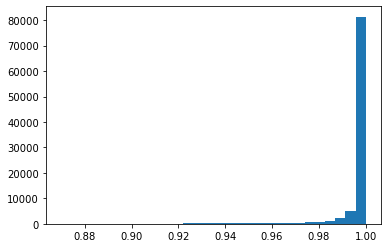

In [10]:
plt.hist(data['face_confidence'], bins=30, range=(0.87, 1.0))
plt.show()

In [11]:
data[data['face_confidence'] > 0.95]['label'].value_counts()

REAL    47517
FAKE    45448
Name: label, dtype: int64

In [12]:
data = data[data['face_confidence'] > 0.95]

In [13]:
# data = data.sample(n=40000, random_state=42)

In [14]:
data['label'].value_counts()

REAL    47517
FAKE    45448
Name: label, dtype: int64

Although, there is a slight imbalance in the dataset as seen above, we sampled the number of "FAKE" videos equal to the number of "REAL" videos in the notebook [Deepfake Detection - Dataset Preparation.ipynb](./Deepfake%20Detection%20-%20Dataset%20Preparation.ipynb)

## Data Splitting

To ensure that images from a video in the train dataset is not in the validation/test dataset, a custom split function was made.

In [15]:
def split_dataframe(data, test_size, column, shuffle=False, random_state=1):
  """Splits the dataframe based on unique values in a given 
  column."""
  # Gets a list of unique videos 
  videos = list(data[column].unique())
  n = len(videos)
  k = int(0.2 * n)

  if shuffle:
    data = data.sample(frac=1)

  # Sets the random state
  random.seed(random_state)
  split_videos = random.sample(videos, k)

  df1 = data[data[column].isin(split_videos)]
  df2 = data[~data[column].isin(split_videos)]
  
  assert(len(df1[df1.isin(df2)].dropna()) == 0)
   
  df2.sort_index(inplace=True)
  
  return df2, df1

In [16]:
TRAIN_SPLIT = 0.2
VAL_SPLIT = 0.25

train_df, test_df = split_dataframe(data=data, 
                                    test_size=TRAIN_SPLIT,
                                    column="video_filename",
                                    shuffle=True,
                                    random_state=42)

train_df, val_df = split_dataframe(data=data, 
                                  test_size=VAL_SPLIT,
                                  column="video_filename",
                                  random_state=42)

C:\Users\Michelle\AppData\Local\Temp\ipykernel_35464\878655541.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_index(inplace=True)


In [17]:
train_df['label'].value_counts()

REAL    38439
FAKE    36143
Name: label, dtype: int64

In [18]:
test_df['label'].value_counts()

FAKE    9305
REAL    9078
Name: label, dtype: int64

In [19]:
val_df['label'].value_counts()

FAKE    9305
REAL    9078
Name: label, dtype: int64

## Data Augmentation 

**Gaussian Noise:**

**Random Erasing:** https://arxiv.org/abs/1708.04896
    - Source code: https://github.com/zhunzhong07/Random-Erasing

In [20]:
def compress_image(image, quality_lower=0.6, quality_higher=1.0, probability=0.5):
  if random.uniform(0,1) > probability:
    return image
  
  scale = random.uniform(quality_lower, quality_higher)
  w = image.shape[0]
  nw = int(image.shape[0] * scale)
  image = cv2.resize(image, (nw, nw), cv2.INTER_AREA)
  image = cv2.resize(image, (w,w), cv2.INTER_AREA)
  return image

In [21]:
def gaussian_noise(image, probability=0.1):
  if random.uniform(0,1) > probability:
    return image
  row,col,ch= image.shape
  mean = 0
  var = 0.01 # slightly reduced
  sigma = var ** 0.5
  gauss = np.random.normal(mean,sigma,(row,col))
  noisy = image
  for i in range(ch):
    noisy[:,:,i] = image[:,:,i] + gauss
  return noisy

In [22]:
def gaussian_blur(image, blur_limit=3, probability=0.05):
  if random.uniform(0,1) > probability:
    return image
  blurred = cv2.GaussianBlur(image, (blur_limit, blur_limit), 0)
  return blurred

In [23]:
def to_gray(image, probability=0.2):
  if random.uniform(0,1) > probability:
    return image
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
  return image

In [24]:
def random_erasing(img, probability=0.5):
  """
  Performs Random Erasing in Random Erasing Data Augmentation by Zhong et al.

  probability: The probability that the operation will be performed.
  sl: min erasing area
  sh: max erasing area
  r1: min aspect ratio
  mean: erasing value

  Note: Code modified for img.shape parameters instead of img.size()
  """
  # Source: https://github.com/zhunzhong07/Random-Erasing
  if random.uniform(0,1) > probability:
    return img

  # Default params
#   mean = [0.4914, 0.4822, 0.4465]
#   mean = [ int(mean[0] * 256), int(mean[1] * 256), int(mean[2] * 256)]
  mean = [0,0,0]
  sl = 0.02
  sh = 0.4
  r1 = 0.3

  for attempt in range(100):
    area = img.shape[0] * img.shape[1]

    target_area = random.uniform(sl, sh) * area
    aspect_ratio = random.uniform(r1, 1/r1)

    h = int(round(math.sqrt(target_area * aspect_ratio)))
    w = int(round(math.sqrt(target_area / aspect_ratio)))

    if w < img.shape[0] and h < img.shape[1]:
        x1 = random.randint(0, img.shape[1] - h)
        y1 = random.randint(0, img.shape[0] - w)
        if img.shape[2] == 3:
            img[x1:x1+h, y1:y1+w, 0] = mean[0]
            img[x1:x1+h, y1:y1+w, 1] = mean[1]
            img[x1:x1+h, y1:y1+w, 2] = mean[2]
        else:
            img[0, x1:x1+h, y1:y1+w] = mean[0]

        return img
  return img

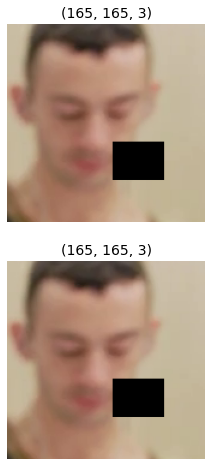

In [25]:
random_image_path = "../extracted_faces/01__kitchen_pan/01__kitchen_pan_1.png"

fig, ax = plt.subplots(2,1,figsize=(12,8))
img1 = cv2.imread(random_image_path)
img2 = random_erasing(img1, probability=1.0)
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].set_title(img1.shape, fontsize=14)
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].set_title(img2.shape, fontsize=14)
ax[1].axis('off')
plt.show()

In [26]:
from keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(ImageDataGenerator):
  '''
  Custom image data generator.
  Allows image compression and random erasing.
  '''
  def __init__(self, 
               gaussian_noise : float = 0., 
               random_erasing : float = 0.,
               **kwargs):
    super().__init__(preprocessing_function=self.custom_augmentations,
                    **kwargs)
  
  def custom_augmentations(self, image):
    image = compress_image(image)
    image = gaussian_noise(image)
    image = gaussian_blur(image)
    image = to_gray(image)
    image = random_erasing(image)
    return image

In [27]:
train_datagen = CustomDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  rotation_range=0.1,
                                  horizontal_flip=True,
                                  brightness_range=[0.5, 1.5],
                                  # Custom augmentation probabilities
                                    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
IMAGE_DIM = 256
BATCH_SIZE = 4

train_generator = train_datagen.flow_from_dataframe(
  dataframe = train_df,
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size = BATCH_SIZE,
  seed = 42,
  class_mode = "binary",
  target_size=(IMAGE_DIM, IMAGE_DIM)
)

valid_generator = train_datagen.flow_from_dataframe(
  dataframe = val_df,
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size = BATCH_SIZE,
  seed = 42,
  class_mode = "binary",
  target_size=(IMAGE_DIM, IMAGE_DIM)
)

test_generator = test_datagen.flow_from_dataframe(
  dataframe = test_df, 
  directory = ".",
  x_col = "image_fullpath",
  y_col = "label",
  batch_size=BATCH_SIZE,
  seed = 42,
  shuffle=False,
  class_mode="binary",
  target_size=(IMAGE_DIM, IMAGE_DIM)
)

Found 74582 validated image filenames belonging to 2 classes.
Found 18383 validated image filenames belonging to 2 classes.
Found 18383 validated image filenames belonging to 2 classes.


## EfficientNet Model

In [30]:
class EfficientNet:
    def __init__(self, input_size, unfreeze=None, dropout=0.5, desc="-new"):
        self.input_size = input_size
        self.unfreeze = unfreeze
        self.dropout = dropout
        self.desc = desc
        self.model = self._initialise_model()
        if self.unfreeze is not None:
            self.unfreeze_layers()
        self.history = None
    
    def _initialise_model(self):
        input_t = keras.Input(shape=self.input_size)
        base_model = keras.applications.EfficientNetB7(
            include_top=False,
            weights="imagenet",
            input_tensor=input_t,
        )
#         base_model.trainable = False
        model = keras.models.Sequential()
        model.add(base_model)
        model.add(keras.layers.GlobalAveragePooling2D()) # v1
#         model.add(keras.layers.Flatten()) # v0
#         model.add(keras.layers.BatchNormalization())
        if self.dropout > 0.0:
            model.add(keras.layers.Dropout(self.dropout))
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        return model
    
    def train_model(self, train_generator, valid_generator,
                    epochs, learning_rate=0.0001,
                    save_model:str=None,
                    verbose=1):
        train_generator.reset()
        valid_generator.reset()
        train_steps = len(train_generator)
        val_steps = len(valid_generator)
        cp_filepath = "../weights/efficientnetb7{}".format(self.desc) + "-{epoch:02d}.hdf5"
        check_point = keras.callbacks.ModelCheckpoint(
            filepath=cp_filepath,
            monitor="val_loss",
            save_best_only=True
        )
#         learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
#             initial_learning_rate=learning_rate,
#             decay_steps=10000,
#             end_learning_rate=0.0001,
#             power=0.9
#         )
        self.model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01),
#             loss='binary_crossentropy',
#             optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#             optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
            optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True, decay=2e-4),
            metrics=['accuracy']
        )
        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=train_steps,
            epochs=epochs,
            validation_data=valid_generator,
            validation_steps=val_steps,
            verbose=verbose,
            callbacks=[check_point]
        )
        
        if save_model is not None:
          self.save_model(save_model)
        return self.history.history
    
    def unfreeze_layers(self):
        self.model.layers[0].trainable = False
        for layer in self.model.layers[0].layers[self.unfreeze:]:
            if not isinstance(layer, keras.layers.BatchNormalization):
                layer.trainable = True
        
    def save_model(self,filepath):
        self.model.save(filepath)
    def get_history(self):
        return self.history.history

### Run 1

Initial training, with the last 61 (block 7) layers unfrozen.
PolynomialDecay enabled.

```
BATCH_SIZE = 16
```

In [151]:
# end:-3, b7:-61. b6:-255, b5:-403, b4:-552, b3:-656
model = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), unfreeze=-61, dropout=0.25, desc="-61")

In [152]:
model.model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 8, 8, 2560)       64097687  
                                                                 
 global_average_pooling2d_14  (None, 2560)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_18 (Dropout)        (None, 2560)              0         
                                                                 
 dense_19 (Dense)            (None, 1)                 2561      
                                                                 
Total params: 64,100,248
Trainable params: 2,561
Non-trainable params: 64,097,687
_________________________________________________________________


In [153]:
for i, layer in enumerate(model.model.layers[0].layers):
    print(i, layer.name, layer.trainable)

0 input_20 False
1 rescaling_19 False
2 normalization_19 False
3 tf.math.truediv_19 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block1c_dwconv False
31 block1c_bn False
32 block1c_activation False
33 block1c_se_squeeze False
34 block1c_se_reshape False
35 block1c_se_reduce False
36 block1c_se_expand False
37 block1c_se_excite False
38 block1c_project_conv False
39 block1c_proje

707 block6j_add False
708 block6k_expand_conv False
709 block6k_expand_bn False
710 block6k_expand_activation False
711 block6k_dwconv False
712 block6k_bn False
713 block6k_activation False
714 block6k_se_squeeze False
715 block6k_se_reshape False
716 block6k_se_reduce False
717 block6k_se_expand False
718 block6k_se_excite False
719 block6k_project_conv False
720 block6k_project_bn False
721 block6k_drop False
722 block6k_add False
723 block6l_expand_conv False
724 block6l_expand_bn False
725 block6l_expand_activation False
726 block6l_dwconv False
727 block6l_bn False
728 block6l_activation False
729 block6l_se_squeeze False
730 block6l_se_reshape False
731 block6l_se_reduce False
732 block6l_se_expand False
733 block6l_se_excite False
734 block6l_project_conv False
735 block6l_project_bn False
736 block6l_drop False
737 block6l_add False
738 block6m_expand_conv False
739 block6m_expand_bn False
740 block6m_expand_activation False
741 block6m_dwconv False
742 block6m_bn False
743 bl

In [154]:
# BATCH_SIZE = 16
history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=5,
                            learning_rate=0.01,
                            save_model="../weights/efficientnetb7-61.h5")

pickle_path = "pickle/efficientnetb7-61.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)

Epoch 1/5
4662/4662 [==============================] - 1367s 289ms/step - loss: 0.7163 - accuracy: 0.5003 - val_loss: 0.6948 - val_accuracy: 0.5065
Epoch 2/5
4662/4662 [==============================] - 1350s 290ms/step - loss: 0.7044 - accuracy: 0.5051 - val_loss: 0.6958 - val_accuracy: 0.4938
Epoch 3/5
4662/4662 [==============================] - 1335s 286ms/step - loss: 0.6955 - accuracy: 0.5072 - val_loss: 0.6930 - val_accuracy: 0.5222
Epoch 4/5
4662/4662 [==============================] - 1342s 288ms/step - loss: 0.6953 - accuracy: 0.5064 - val_loss: 0.6938 - val_accuracy: 0.4938
Epoch 5/5
4662/4662 [==============================] - 1341s 288ms/step - loss: 0.6947 - accuracy: 0.5077 - val_loss: 0.6947 - val_accuracy: 0.4938


Accuracy is increasing, but learning rate is *veeerry* slow. Should probably modify learning rate method.

### Run 2

Modified EfficientNet class:
- Removed polynomial decay for learning rate. Replaced with a static learning rate 0.01. No decay.

In [34]:
# end:-3, b7:-61. b6:-255, b5:-403, b4:-552, b3:-656
model = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), unfreeze=-61, dropout=0.25, desc="-61-staticlr")

# BATCH_SIZE = 16
history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=5,
                            learning_rate=0.01,
                            save_model="../weights/efficientnetb7-61-staticlr.h5")

pickle_path = "pickle/efficientnetb7-61-staticlr.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)

Epoch 1/5
4662/4662 [==============================] - 1305s 276ms/step - loss: 0.7237 - accuracy: 0.5022 - val_loss: 0.6947 - val_accuracy: 0.4938
Epoch 2/5
4662/4662 [==============================] - 1268s 272ms/step - loss: 0.7246 - accuracy: 0.5014 - val_loss: 0.6960 - val_accuracy: 0.5062
Epoch 3/5
4662/4662 [==============================] - 1290s 277ms/step - loss: 0.7263 - accuracy: 0.5053 - val_loss: 0.7362 - val_accuracy: 0.4938
Epoch 4/5
4662/4662 [==============================] - 1280s 275ms/step - loss: 0.7281 - accuracy: 0.5016 - val_loss: 0.7051 - val_accuracy: 0.5062
Epoch 5/5
4662/4662 [==============================] - 1282s 275ms/step - loss: 0.7250 - accuracy: 0.5014 - val_loss: 0.7161 - val_accuracy: 0.4938


### Run 3

Evaluate efficientnet with a varying number of trainable layers.

In [35]:
del model, history

# end:-3, b7:-61. b6:-255, b5:-403, b4:-552, b3:-656
model = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), unfreeze=-255, dropout=0.25, desc="-255")

history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=5,
                            learning_rate=0.01,
                            save_model="../weights/efficientnetb7-255.h5")

pickle_path = "pickle/efficientnetb7-255.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)

Epoch 1/5
4662/4662 [==============================] - 1338s 283ms/step - loss: 0.7251 - accuracy: 0.5029 - val_loss: 0.7014 - val_accuracy: 0.5062
Epoch 2/5
4662/4662 [==============================] - 1344s 288ms/step - loss: 0.7259 - accuracy: 0.5044 - val_loss: 0.7214 - val_accuracy: 0.5062
Epoch 3/5
4662/4662 [==============================] - 1302s 279ms/step - loss: 0.7257 - accuracy: 0.5052 - val_loss: 0.7155 - val_accuracy: 0.4938
Epoch 4/5
4662/4662 [==============================] - 1305s 280ms/step - loss: 0.7274 - accuracy: 0.5027 - val_loss: 0.6929 - val_accuracy: 0.5084
Epoch 5/5
4662/4662 [==============================] - 1303s 279ms/step - loss: 0.7271 - accuracy: 0.5041 - val_loss: 0.7194 - val_accuracy: 0.5062


In [36]:
del model, history

# end:-3, b7:-61. b6:-255, b5:-403, b4:-552, b3:-656
model = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), unfreeze=-403, dropout=0.25, desc="-403")

history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=5,
                            learning_rate=0.01,
                            save_model="../weights/efficientnetb7-403.h5")

pickle_path = "pickle/efficientnetb7-403.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)

Epoch 1/5
4662/4662 [==============================] - 1339s 283ms/step - loss: 0.7246 - accuracy: 0.4994 - val_loss: 0.7101 - val_accuracy: 0.4938
Epoch 2/5
4662/4662 [==============================] - 1324s 284ms/step - loss: 0.7287 - accuracy: 0.5012 - val_loss: 0.7070 - val_accuracy: 0.4938
Epoch 3/5
4662/4662 [==============================] - 1321s 283ms/step - loss: 0.7255 - accuracy: 0.4996 - val_loss: 0.6993 - val_accuracy: 0.5062
Epoch 4/5
4662/4662 [==============================] - 1362s 292ms/step - loss: 0.7266 - accuracy: 0.5009 - val_loss: 0.7023 - val_accuracy: 0.4938
Epoch 5/5
4662/4662 [==============================] - 1333s 286ms/step - loss: 0.7283 - accuracy: 0.5025 - val_loss: 0.7030 - val_accuracy: 0.5062


In [37]:
del model, history

# end:-3, b7:-61. b6:-255, b5:-403, b4:-552, b3:-656
model = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), unfreeze=-552, dropout=0.25, desc=
                     "-552")

history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=5,
                            learning_rate=0.01,
                            save_model="../weights/efficientnetb7-552.h5")

pickle_path = "pickle/efficientnetb7-552.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)

Epoch 1/5
4662/4662 [==============================] - 1369s 290ms/step - loss: 0.7259 - accuracy: 0.5045 - val_loss: 0.6960 - val_accuracy: 0.5069
Epoch 2/5
4662/4662 [==============================] - 1338s 287ms/step - loss: 0.7248 - accuracy: 0.5059 - val_loss: 0.6951 - val_accuracy: 0.4938
Epoch 3/5
4662/4662 [==============================] - 1385s 297ms/step - loss: 0.7271 - accuracy: 0.4977 - val_loss: 0.7122 - val_accuracy: 0.4938
Epoch 4/5
4662/4662 [==============================] - 1388s 298ms/step - loss: 0.7238 - accuracy: 0.5061 - val_loss: 0.7200 - val_accuracy: 0.5062
Epoch 5/5
4662/4662 [==============================] - 1385s 297ms/step - loss: 0.7275 - accuracy: 0.5032 - val_loss: 0.6955 - val_accuracy: 0.4938


### Run 4

Increased SGD+momentum learning rate to 0.1.

In [38]:
del model, history

# end:-3, b7:-61. b6:-255, b5:-403, b4:-552, b3:-656
model = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), unfreeze=-61, dropout=0.25, desc="-61-staticlr")

# BATCH_SIZE = 16
history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=5,
                            learning_rate=0.1,
                            save_model="../weights/efficientnetb7-61-staticlr.h5")

pickle_path = "pickle/efficientnetb7-61-staticlr.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)

Epoch 1/5
4662/4662 [==============================] - 1396s 295ms/step - loss: 1.3878 - accuracy: 0.5006 - val_loss: 0.8563 - val_accuracy: 0.4938
Epoch 2/5
4662/4662 [==============================] - 1380s 296ms/step - loss: 1.3175 - accuracy: 0.5014 - val_loss: 2.4599 - val_accuracy: 0.4938
Epoch 3/5
4662/4662 [==============================] - 1381s 296ms/step - loss: 1.2865 - accuracy: 0.5024 - val_loss: 0.7073 - val_accuracy: 0.4938
Epoch 4/5
4662/4662 [==============================] - 1382s 297ms/step - loss: 1.3105 - accuracy: 0.5020 - val_loss: 0.8381 - val_accuracy: 0.4938
Epoch 5/5
4662/4662 [==============================] - 1350s 289ms/step - loss: 1.3319 - accuracy: 0.5009 - val_loss: 1.7634 - val_accuracy: 0.4938


### Run 5

- **Optimizer:** `RMSprop(lr=0.0005)`
- Binary crossentropy with no label smoothing.
- BATCH SIZE = 16
- Allowed batch normalisation layers to be trainable.

**Modification:**
- Decreased compression quality range from (0.6, 1.0) to (0.8, 1.0)
- Decreased brightnes range from [0.5, 1.5] to [0.8, 1.2]

In [53]:
# del model, history

# end:-3, b7:-61. b6:-255, b5:-403, b4:-552, b3:-656, #b2:-760, #b1:-806
model = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), unfreeze=-656, dropout=0.25, desc="-rmsprop")

# BATCH_SIZE = 16
history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=5,
                            learning_rate=0.01,
                            save_model="../weights/efficientnetb7-rmsprop.h5")

pickle_path = "pickle/efficientnetb7-rmsprop.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)

Epoch 1/5
4662/4662 [==============================] - 1454s 308ms/step - loss: 0.6822 - accuracy: 0.5608 - val_loss: 0.6822 - val_accuracy: 0.5613
Epoch 2/5
4662/4662 [==============================] - 1402s 301ms/step - loss: 0.6769 - accuracy: 0.5742 - val_loss: 0.6882 - val_accuracy: 0.5552
Epoch 3/5
 236/4662 [>.............................] - ETA: 17:57 - loss: 0.6769 - accuracy: 0.5710

KeyboardInterrupt: 

### Run 6

From the runs above with the initial layers frozen, we can determine that the model performs poorly on the deepfake data even as we increase the number of trainable layers/blocks in the model.

**Modifications:**
- All layers trainable. Imagenet weights only used to initialise the model.
- `BATCH_SIZE = 4` largest batch size that could fit into memory.

In [57]:
# end:-3, b7:-61. b6:-255, b5:-403, b4:-552, b3:-656, #b2:-760, #b1:-806
model = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), unfreeze=None, dropout=0.25, desc="-full")

for i, layer in enumerate(model.model.layers[0].layers):
    print(i, layer.name, layer.trainable)

0 input_6 True
1 rescaling_5 True
2 normalization_5 True
3 tf.math.truediv_5 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block1c_dwconv True
31 block1c_bn True
32 block1c_activation True
33 block1c_se_squeeze True
34 block1c_se_reshape True
35 block1c_se_reduce True
36 block1c_se_expand True
37 block1c_se_excite True
38 block1c_project_conv True
39 block1c_project_bn True
40 block1c_drop True
41 block1c_

In [58]:
# BATCH_SIZE = 4
history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=5,
                            learning_rate=0.005, #initial
                            save_model="../weights/efficientnetb7-full.h5")

pickle_path = "pickle/efficientnetb7-full.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)

Epoch 1/5
18646/18646 [==============================] - 4887s 261ms/step - loss: 0.3022 - accuracy: 0.8702 - val_loss: 0.7110 - val_accuracy: 0.6429
Epoch 2/5
18646/18646 [==============================] - 4796s 257ms/step - loss: 0.1460 - accuracy: 0.9507 - val_loss: 0.3557 - val_accuracy: 0.8715
Epoch 3/5
18646/18646 [==============================] - 4817s 258ms/step - loss: 0.1152 - accuracy: 0.9636 - val_loss: 0.2967 - val_accuracy: 0.8900
Epoch 4/5
18646/18646 [==============================] - 4899s 263ms/step - loss: 0.1015 - accuracy: 0.9700 - val_loss: 0.2311 - val_accuracy: 0.9169
Epoch 5/5
18646/18646 [==============================] - 4822s 259ms/step - loss: 0.0931 - accuracy: 0.9735 - val_loss: 0.7819 - val_accuracy: 0.6703


### Run 7
- Increased probability for random erasing: `0.3 -> 0.5`
- Set image compression quality: `[0.6, 1.0]`
- Set image brightness range: `[0.5, 1.5]`
- Increased **sgd decay**: `1e-4 -> 2e-4`

In [ ]:
# end:-3, b7:-61. b6:-255, b5:-403, b4:-552, b3:-656, #b2:-760, #b1:-806
model = EfficientNet(input_size=(IMAGE_DIM, IMAGE_DIM,3), unfreeze=None, dropout=0.25, desc="-full-v2")

# BATCH_SIZE = 4
history = model.train_model(train_generator=train_generator,
                            valid_generator=valid_generator,
                            epochs=10,
                            learning_rate=0.005, #initial
                            save_model="../weights/efficientnetb7-full-v2.h5")

pickle_path = "pickle/efficientnetb7-full-v2.pickle"

with open(pickle_path, "wb") as f:
  pickle.dump(history, f)

Epoch 1/10
 1724/18646 [=>............................] - ETA: 1:09:33 - loss: 0.6156 - accuracy: 0.6568

## Model load

In [24]:
pickle_path = "pickle/efficientnetb7-v3.pickle"

with open(pickle_path, "rb") as f:
  history = pickle.load(f)

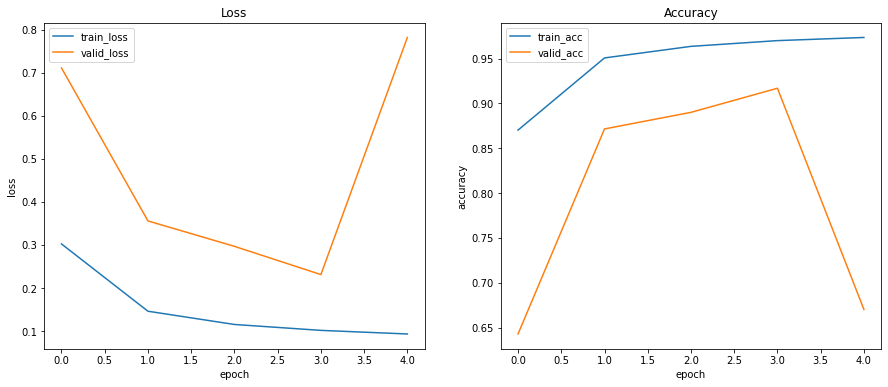

In [59]:
def plot_loss_and_accuracy(history, figsize=(15,6)):
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  ax[0].plot(history['loss'], label='train_loss')
  ax[0].plot(history['val_loss'], label='valid_loss')
  ax[0].set_title("Loss")
  ax[0].set_xlabel("epoch")
  ax[0].set_ylabel("loss")
  ax[0].legend()
  ax[1].plot(history['accuracy'], label='train_acc')
  ax[1].plot(history['val_accuracy'], label='valid_acc')
  ax[1].set_title("Accuracy")
  ax[1].set_xlabel("epoch")
  ax[1].set_ylabel("accuracy")
  ax[1].legend()

  plt.show()

    
plot_loss_and_accuracy(history)

## Model Evaluations

In [60]:
def model_predict(model, test_generator):
    # Runs prediction on test dataset
    test_generator.reset()
    pred = model.predict(test_generator,steps=len(test_generator), verbose=1)
    
    # Creates a dictionary to search for the video_filename: array of frame predictions
    real_labels = test_generator.labels
    filenames = test_generator.filenames
    prediction = {}
    real_prediction = {}
    for f, p, r in zip(filenames, pred, real_labels):
        pred_video_filename = test_df[test_df['image_fullpath'] == f]['video_filename'].iloc[0]
        if pred_video_filename in prediction.keys():
            prediction[pred_video_filename].append(p[0])
            real_prediction[pred_video_filename].append(r)
        else:
            prediction[pred_video_filename] = [ p[0] ]
            real_prediction[pred_video_filename] = [r]

    # Averages the prediction scores for each video
    real_prediction = { k: int(sum(v)/len(v)) for k,v in real_prediction.items() }
    
    pred_vid_filenames = list(prediction.keys())
    pred_vid = list(prediction.values())
    real_indices = list(real_prediction.values())
    
    return pred_vid_filenames, pred_vid, real_indices

def predict_indices(pred, thresh=0.5):
    return [1 if p > thresh else 0 for p in pred ]

from sklearn.metrics import classification_report

def show_classification_report(test_y, pred_y):
    report = classification_report(test_y, pred_y, digits=4, zero_division=0)
    print(report)
    
import seaborn as sns
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(test_y, pred_y, axis_labels):
    confusion = confusion_matrix(test_y, pred_y)
    confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
    fig, ax = plt.subplots(figsize=(8,8))
    ax = sns.heatmap(confusion_normalized, 
                     xticklabels=axis_labels, 
                     yticklabels=axis_labels,
                     cmap='Blues', 
                     annot=True,
                     fmt = '.2f',
                     square = True
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [87]:
# v0 - Flatten
# effnet = keras.models.load_model("../weights/efficientnetb7-v7-02.hdf5")
effnet = keras.models.load_model("../weights/efficientnetb7-full-04.hdf5")

test_generator.reset()
image_loss, image_acc = effnet.evaluate(test_generator)
test_x, pred_y, test_y = model_predict(effnet, test_generator)

image_loss, image_acc

4596/4596 [==============================] - 225s 48ms/step


(0.15181584656238556, 0.9518576860427856)

In [88]:
print("Image loss     :", image_loss)
print("Image accuracy :", image_acc)

Image loss     : 0.15181584656238556
Image accuracy : 0.9518576860427856


In [89]:
train_generator.class_indices

{'FAKE': 0, 'REAL': 1}

              precision    recall  f1-score   support

           0     0.9966    0.9642    0.9801       307
           1     0.9637    0.9966    0.9799       293

    accuracy                         0.9800       600
   macro avg     0.9802    0.9804    0.9800       600
weighted avg     0.9805    0.9800    0.9800       600



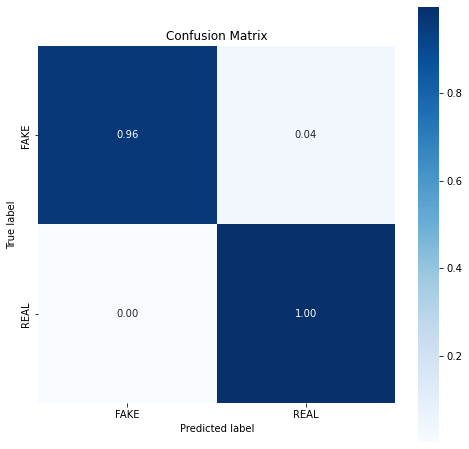

In [90]:
# Converts predictions to binary
pred_y_indices = predict_indices(pred_y, thresh=0.5)

show_classification_report(test_y, pred_y_indices)

axis_labels = list(test_generator.class_indices)
show_confusion_matrix(test_y, pred_y_indices, axis_labels)